In [1]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pathlib
from keras.optimizers import Adam
from keras.models import load_model

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
data_dir = pathlib.Path('./dataset')
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.jpeg'))) + len(list(data_dir.glob('*/*.png')))

print(f'total number of data: {image_count}')

total number of data: 396


In [4]:
batch_size = 16
img_height = 112
img_width = 112

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 396 files belonging to 6 classes.
Using 278 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 396 files belonging to 6 classes.
Using 118 files for validation.


In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['catfish_메기', 'crucian carp_붕어', 'flatfish_광어', 'golden mandarin fish_쏘가리', 'red snapper_참돔', 'rockfish_우럭']
6


In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 112, 112, 3)
(16,)


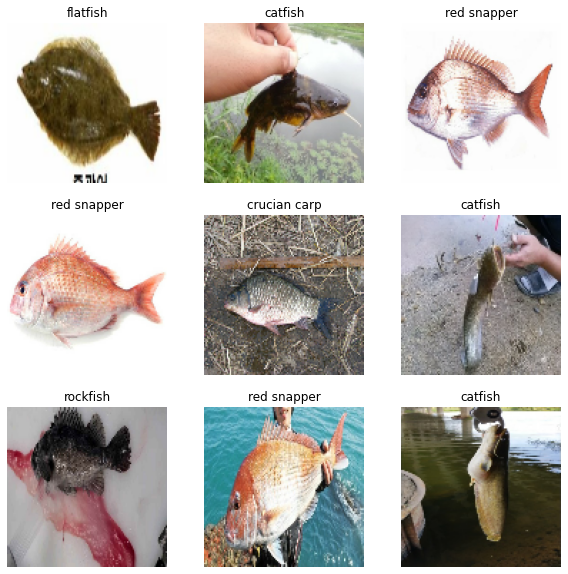

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])][:len(class_names[int(labels[i])]) - 3])
        plt.axis("off")

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
model = tf.keras.Sequential()

# images as input
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# adding layers
# batch normalization, dropout = overfitting 방지rfitting 방지
model.add(layers.Conv2D(64, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

model.add(layers.Conv2D(128, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

model.add(layers.Conv2D(256, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

model.add(layers.Conv2D(512, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# 2차원의 그림을 1차원을 바꿔준다
model.add(layers.Flatten())

# 입력계층의 갯수 정하기
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

# output layer
# 가진 클래스의 갯수만큼 출력층 만들어주기
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 112, 112, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       7

In [13]:
opt = Adam(lr=0.00001)

model.compile(
    optimizer=opt,
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [14]:
epochs = 1000
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

# hdf5_file = "./model/improved_model_2.hdf5"
# model.save_weights(hdf5_file)

Epoch 1/1000
18/18 [==============================] - 9s 234ms/step - loss: 3.6552 - accuracy: 0.1726 - val_loss: 1.7780 - val_accuracy: 0.2627
Epoch 2/1000
18/18 [==============================] - 2s 133ms/step - loss: 1.4228 - accuracy: 0.5657 - val_loss: 1.7684 - val_accuracy: 0.2627
Epoch 3/1000
18/18 [==============================] - 2s 134ms/step - loss: 0.8609 - accuracy: 0.7271 - val_loss: 1.7802 - val_accuracy: 0.2627
Epoch 4/1000
18/18 [==============================] - 2s 133ms/step - loss: 0.7392 - accuracy: 0.7574 - val_loss: 1.8184 - val_accuracy: 0.2627
Epoch 5/1000
18/18 [==============================] - 2s 133ms/step - loss: 0.6158 - accuracy: 0.7862 - val_loss: 1.8741 - val_accuracy: 0.2627
Epoch 6/1000
18/18 [==============================] - 2s 133ms/step - loss: 0.2950 - accuracy: 0.8988 - val_loss: 1.9931 - val_accuracy: 0.2627
Epoch 7/1000
18/18 [==============================] - 2s 134ms/step - loss: 0.1634 - accuracy: 0.9525 - val_loss: 2.1895 - val_accuracy:

18/18 [==============================] - 2s 136ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.0484 - val_accuracy: 0.6949
Epoch 58/1000
18/18 [==============================] - 2s 135ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.0501 - val_accuracy: 0.6949
Epoch 59/1000
18/18 [==============================] - 2s 136ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.9127 - val_accuracy: 0.7119
Epoch 60/1000
18/18 [==============================] - 2s 135ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.9130 - val_accuracy: 0.7203
Epoch 61/1000
18/18 [==============================] - 2s 136ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.9048 - val_accuracy: 0.7203
Epoch 62/1000
18/18 [==============================] - 2s 136ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.9144 - val_accuracy: 0.7288
Epoch 63/1000
18/18 [==============================] - 2s 136ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.8998 - val_accuracy: 0.7034

18/18 [==============================] - 2s 136ms/step - loss: 7.7483e-04 - accuracy: 1.0000 - val_loss: 1.1859 - val_accuracy: 0.6780
Epoch 114/1000
18/18 [==============================] - 2s 136ms/step - loss: 5.7865e-04 - accuracy: 1.0000 - val_loss: 1.1233 - val_accuracy: 0.6780
Epoch 115/1000
18/18 [==============================] - 2s 136ms/step - loss: 9.9491e-04 - accuracy: 1.0000 - val_loss: 1.0485 - val_accuracy: 0.6864
Epoch 116/1000
18/18 [==============================] - 2s 135ms/step - loss: 6.2926e-04 - accuracy: 1.0000 - val_loss: 1.0446 - val_accuracy: 0.6949
Epoch 117/1000
18/18 [==============================] - 2s 137ms/step - loss: 6.6090e-04 - accuracy: 1.0000 - val_loss: 1.0449 - val_accuracy: 0.6949
Epoch 118/1000
18/18 [==============================] - 2s 136ms/step - loss: 4.8223e-04 - accuracy: 1.0000 - val_loss: 1.0383 - val_accuracy: 0.7034
Epoch 119/1000
18/18 [==============================] - 2s 136ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss:

Epoch 168/1000
18/18 [==============================] - 2s 136ms/step - loss: 1.7790e-04 - accuracy: 1.0000 - val_loss: 1.0755 - val_accuracy: 0.7034
Epoch 169/1000
18/18 [==============================] - 2s 137ms/step - loss: 2.4068e-04 - accuracy: 1.0000 - val_loss: 1.0659 - val_accuracy: 0.7034
Epoch 170/1000
18/18 [==============================] - 2s 137ms/step - loss: 9.6195e-05 - accuracy: 1.0000 - val_loss: 1.0687 - val_accuracy: 0.7034
Epoch 171/1000
18/18 [==============================] - 2s 139ms/step - loss: 2.7415e-04 - accuracy: 1.0000 - val_loss: 1.0830 - val_accuracy: 0.6949
Epoch 172/1000
18/18 [==============================] - 3s 142ms/step - loss: 0.0020 - accuracy: 0.9982 - val_loss: 1.0473 - val_accuracy: 0.7034
Epoch 173/1000
18/18 [==============================] - 2s 139ms/step - loss: 4.2122e-04 - accuracy: 1.0000 - val_loss: 1.0914 - val_accuracy: 0.6949
Epoch 174/1000
18/18 [==============================] - 2s 138ms/step - loss: 0.0073 - accuracy: 0.9958 

18/18 [==============================] - 2s 138ms/step - loss: 0.2331 - accuracy: 0.9353 - val_loss: 2.2716 - val_accuracy: 0.6525
Epoch 224/1000
18/18 [==============================] - 2s 137ms/step - loss: 0.1275 - accuracy: 0.9444 - val_loss: 2.2658 - val_accuracy: 0.6780
Epoch 225/1000
18/18 [==============================] - 2s 139ms/step - loss: 0.1841 - accuracy: 0.9540 - val_loss: 2.9410 - val_accuracy: 0.6017
Epoch 226/1000
18/18 [==============================] - 2s 138ms/step - loss: 0.0975 - accuracy: 0.9701 - val_loss: 2.3335 - val_accuracy: 0.7034
Epoch 227/1000
18/18 [==============================] - 2s 138ms/step - loss: 0.0767 - accuracy: 0.9664 - val_loss: 3.1842 - val_accuracy: 0.6441
Epoch 228/1000
18/18 [==============================] - 2s 137ms/step - loss: 0.0827 - accuracy: 0.9693 - val_loss: 2.5981 - val_accuracy: 0.6525
Epoch 229/1000
18/18 [==============================] - 2s 138ms/step - loss: 0.0738 - accuracy: 0.9738 - val_loss: 1.9461 - val_accuracy: 

Epoch 279/1000
18/18 [==============================] - 2s 137ms/step - loss: 0.0067 - accuracy: 0.9952 - val_loss: 2.7572 - val_accuracy: 0.7034
Epoch 280/1000
18/18 [==============================] - 2s 137ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.7262 - val_accuracy: 0.7203
Epoch 281/1000
18/18 [==============================] - 2s 139ms/step - loss: 1.5895e-04 - accuracy: 1.0000 - val_loss: 2.4860 - val_accuracy: 0.7373
Epoch 282/1000
18/18 [==============================] - 3s 140ms/step - loss: 6.0669e-04 - accuracy: 1.0000 - val_loss: 2.3735 - val_accuracy: 0.7203
Epoch 283/1000
18/18 [==============================] - 2s 138ms/step - loss: 8.9698e-05 - accuracy: 1.0000 - val_loss: 2.3231 - val_accuracy: 0.7203
Epoch 284/1000
18/18 [==============================] - 2s 137ms/step - loss: 1.1203e-04 - accuracy: 1.0000 - val_loss: 2.3049 - val_accuracy: 0.7203
Epoch 285/1000
18/18 [==============================] - 2s 136ms/step - loss: 6.4435e-05 - accuracy: 1.0000 

Epoch 334/1000
18/18 [==============================] - 2s 136ms/step - loss: 7.3008e-05 - accuracy: 1.0000 - val_loss: 2.3549 - val_accuracy: 0.7034
Epoch 335/1000
18/18 [==============================] - 2s 135ms/step - loss: 3.4722e-05 - accuracy: 1.0000 - val_loss: 2.3400 - val_accuracy: 0.7034
Epoch 336/1000
18/18 [==============================] - 2s 136ms/step - loss: 3.6943e-06 - accuracy: 1.0000 - val_loss: 2.3348 - val_accuracy: 0.7034
Epoch 337/1000
18/18 [==============================] - 2s 137ms/step - loss: 2.6118e-06 - accuracy: 1.0000 - val_loss: 2.3327 - val_accuracy: 0.7034
Epoch 338/1000
18/18 [==============================] - 2s 136ms/step - loss: 4.9304e-06 - accuracy: 1.0000 - val_loss: 2.3309 - val_accuracy: 0.7034
Epoch 339/1000
18/18 [==============================] - 2s 137ms/step - loss: 2.8925e-05 - accuracy: 1.0000 - val_loss: 2.3283 - val_accuracy: 0.7034
Epoch 340/1000
18/18 [==============================] - 2s 136ms/step - loss: 8.6040e-07 - accuracy:

Epoch 389/1000
18/18 [==============================] - 2s 136ms/step - loss: 4.9292e-06 - accuracy: 1.0000 - val_loss: 2.5967 - val_accuracy: 0.7034
Epoch 390/1000
18/18 [==============================] - 2s 136ms/step - loss: 5.9463e-05 - accuracy: 1.0000 - val_loss: 2.5887 - val_accuracy: 0.7034
Epoch 391/1000
18/18 [==============================] - 2s 136ms/step - loss: 7.2375e-06 - accuracy: 1.0000 - val_loss: 2.5878 - val_accuracy: 0.7034
Epoch 392/1000
18/18 [==============================] - 2s 139ms/step - loss: 0.0083 - accuracy: 0.9943 - val_loss: 2.6897 - val_accuracy: 0.7288
Epoch 393/1000
18/18 [==============================] - 2s 139ms/step - loss: 0.0042 - accuracy: 0.9985 - val_loss: 2.1689 - val_accuracy: 0.7458
Epoch 394/1000
18/18 [==============================] - 3s 140ms/step - loss: 0.0046 - accuracy: 0.9979 - val_loss: 2.9842 - val_accuracy: 0.6780
Epoch 395/1000
18/18 [==============================] - 2s 138ms/step - loss: 0.0368 - accuracy: 0.9867 - val_lo

18/18 [==============================] - 3s 151ms/step - loss: 1.9588e-05 - accuracy: 1.0000 - val_loss: 2.5955 - val_accuracy: 0.7288
Epoch 445/1000
18/18 [==============================] - 3s 151ms/step - loss: 2.6100e-04 - accuracy: 1.0000 - val_loss: 2.6296 - val_accuracy: 0.7288
Epoch 446/1000
18/18 [==============================] - 3s 150ms/step - loss: 1.4635e-05 - accuracy: 1.0000 - val_loss: 2.6437 - val_accuracy: 0.7288
Epoch 447/1000
18/18 [==============================] - 3s 149ms/step - loss: 0.0031 - accuracy: 0.9979 - val_loss: 2.3644 - val_accuracy: 0.7458
Epoch 448/1000
18/18 [==============================] - 3s 150ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 2.6438 - val_accuracy: 0.7288
Epoch 449/1000
18/18 [==============================] - 3s 147ms/step - loss: 6.8705e-04 - accuracy: 1.0000 - val_loss: 2.5487 - val_accuracy: 0.7203
Epoch 450/1000
18/18 [==============================] - 3s 148ms/step - loss: 2.9447e-04 - accuracy: 1.0000 - val_loss: 2.4

Epoch 499/1000
18/18 [==============================] - 2s 138ms/step - loss: 8.3452e-04 - accuracy: 1.0000 - val_loss: 3.4206 - val_accuracy: 0.6949
Epoch 500/1000
18/18 [==============================] - 2s 137ms/step - loss: 3.7804e-04 - accuracy: 1.0000 - val_loss: 3.1848 - val_accuracy: 0.7288
Epoch 501/1000
18/18 [==============================] - 2s 138ms/step - loss: 2.5529e-05 - accuracy: 1.0000 - val_loss: 3.1192 - val_accuracy: 0.7288
Epoch 502/1000
18/18 [==============================] - 2s 139ms/step - loss: 3.6270e-06 - accuracy: 1.0000 - val_loss: 3.0719 - val_accuracy: 0.7288
Epoch 503/1000
18/18 [==============================] - 2s 138ms/step - loss: 3.4997e-06 - accuracy: 1.0000 - val_loss: 3.0531 - val_accuracy: 0.7373
Epoch 504/1000
18/18 [==============================] - 2s 136ms/step - loss: 7.3980e-07 - accuracy: 1.0000 - val_loss: 3.0410 - val_accuracy: 0.7373
Epoch 505/1000
18/18 [==============================] - 2s 139ms/step - loss: 6.4295e-07 - accuracy:

Epoch 554/1000
18/18 [==============================] - 2s 138ms/step - loss: 9.5458e-08 - accuracy: 1.0000 - val_loss: 2.6394 - val_accuracy: 0.7542
Epoch 555/1000
18/18 [==============================] - 2s 138ms/step - loss: 2.0531e-07 - accuracy: 1.0000 - val_loss: 2.6398 - val_accuracy: 0.7542
Epoch 556/1000
18/18 [==============================] - 2s 136ms/step - loss: 3.4118e-07 - accuracy: 1.0000 - val_loss: 2.6400 - val_accuracy: 0.7542
Epoch 557/1000
18/18 [==============================] - 2s 136ms/step - loss: 2.0663e-07 - accuracy: 1.0000 - val_loss: 2.6403 - val_accuracy: 0.7542
Epoch 558/1000
18/18 [==============================] - 2s 140ms/step - loss: 9.7328e-08 - accuracy: 1.0000 - val_loss: 2.6405 - val_accuracy: 0.7542
Epoch 559/1000
18/18 [==============================] - 2s 138ms/step - loss: 1.9512e-08 - accuracy: 1.0000 - val_loss: 2.6407 - val_accuracy: 0.7542
Epoch 560/1000
18/18 [==============================] - 3s 142ms/step - loss: 1.0918e-07 - accuracy:

18/18 [==============================] - 2s 137ms/step - loss: 2.8476e-07 - accuracy: 1.0000 - val_loss: 2.4899 - val_accuracy: 0.7627
Epoch 609/1000
18/18 [==============================] - 2s 137ms/step - loss: 4.0669e-08 - accuracy: 1.0000 - val_loss: 2.4900 - val_accuracy: 0.7627
Epoch 610/1000
18/18 [==============================] - 2s 138ms/step - loss: 3.1286e-07 - accuracy: 1.0000 - val_loss: 2.4903 - val_accuracy: 0.7627
Epoch 611/1000
18/18 [==============================] - 3s 140ms/step - loss: 4.7535e-04 - accuracy: 1.0000 - val_loss: 2.7026 - val_accuracy: 0.7627
Epoch 612/1000
18/18 [==============================] - 2s 137ms/step - loss: 1.6765e-06 - accuracy: 1.0000 - val_loss: 3.0732 - val_accuracy: 0.7034
Epoch 613/1000
18/18 [==============================] - 2s 136ms/step - loss: 8.7169e-04 - accuracy: 1.0000 - val_loss: 2.6984 - val_accuracy: 0.7373
Epoch 614/1000
18/18 [==============================] - 2s 137ms/step - loss: 1.9182e-05 - accuracy: 1.0000 - val_l

18/18 [==============================] - 3s 142ms/step - loss: 0.0396 - accuracy: 0.9859 - val_loss: 4.7069 - val_accuracy: 0.7203
Epoch 664/1000
18/18 [==============================] - 3s 142ms/step - loss: 0.0120 - accuracy: 0.9920 - val_loss: 4.0041 - val_accuracy: 0.7288
Epoch 665/1000
18/18 [==============================] - 3s 142ms/step - loss: 0.0095 - accuracy: 0.9969 - val_loss: 4.7805 - val_accuracy: 0.6780
Epoch 666/1000
18/18 [==============================] - 3s 143ms/step - loss: 0.1007 - accuracy: 0.9826 - val_loss: 4.8490 - val_accuracy: 0.7034
Epoch 667/1000
18/18 [==============================] - 3s 143ms/step - loss: 4.5060e-04 - accuracy: 1.0000 - val_loss: 5.2926 - val_accuracy: 0.7119
Epoch 668/1000
18/18 [==============================] - 3s 143ms/step - loss: 0.1182 - accuracy: 0.9826 - val_loss: 4.5560 - val_accuracy: 0.7119
Epoch 669/1000
18/18 [==============================] - 3s 142ms/step - loss: 1.9507e-04 - accuracy: 1.0000 - val_loss: 4.5084 - val_ac

18/18 [==============================] - 2s 137ms/step - loss: 1.5853e-06 - accuracy: 1.0000 - val_loss: 4.0469 - val_accuracy: 0.7203
Epoch 719/1000
18/18 [==============================] - 2s 137ms/step - loss: 5.2663e-04 - accuracy: 1.0000 - val_loss: 3.9722 - val_accuracy: 0.7203
Epoch 720/1000
18/18 [==============================] - 2s 138ms/step - loss: 0.0098 - accuracy: 0.9920 - val_loss: 3.4688 - val_accuracy: 0.7373
Epoch 721/1000
18/18 [==============================] - 2s 137ms/step - loss: 8.0987e-07 - accuracy: 1.0000 - val_loss: 3.4987 - val_accuracy: 0.7288
Epoch 722/1000
18/18 [==============================] - 2s 137ms/step - loss: 0.0079 - accuracy: 0.9979 - val_loss: 4.0208 - val_accuracy: 0.7288
Epoch 723/1000
18/18 [==============================] - 2s 138ms/step - loss: 9.9464e-04 - accuracy: 1.0000 - val_loss: 4.3581 - val_accuracy: 0.7203
Epoch 724/1000
18/18 [==============================] - 2s 136ms/step - loss: 6.3585e-06 - accuracy: 1.0000 - val_loss: 4.3

Epoch 773/1000
18/18 [==============================] - 3s 141ms/step - loss: 5.0704e-07 - accuracy: 1.0000 - val_loss: 3.0887 - val_accuracy: 0.7797
Epoch 774/1000
18/18 [==============================] - 2s 138ms/step - loss: 1.2741e-06 - accuracy: 1.0000 - val_loss: 3.0998 - val_accuracy: 0.7881
Epoch 775/1000
18/18 [==============================] - 3s 140ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 3.0352 - val_accuracy: 0.7712
Epoch 776/1000
18/18 [==============================] - 2s 139ms/step - loss: 1.2520e-06 - accuracy: 1.0000 - val_loss: 3.0357 - val_accuracy: 0.7712
Epoch 777/1000
18/18 [==============================] - 2s 136ms/step - loss: 3.1487e-07 - accuracy: 1.0000 - val_loss: 3.0449 - val_accuracy: 0.7712
Epoch 778/1000
18/18 [==============================] - 2s 138ms/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 3.0617 - val_accuracy: 0.7458
Epoch 779/1000
18/18 [==============================] - 2s 139ms/step - loss: 5.7047e-06 - accuracy: 1.0000 

Epoch 828/1000
18/18 [==============================] - 2s 138ms/step - loss: 2.0322e-08 - accuracy: 1.0000 - val_loss: 3.3564 - val_accuracy: 0.7712
Epoch 829/1000
18/18 [==============================] - 2s 138ms/step - loss: 3.4807e-08 - accuracy: 1.0000 - val_loss: 3.3568 - val_accuracy: 0.7712
Epoch 830/1000
18/18 [==============================] - 2s 138ms/step - loss: 2.5430e-09 - accuracy: 1.0000 - val_loss: 3.3571 - val_accuracy: 0.7712
Epoch 831/1000
18/18 [==============================] - 2s 137ms/step - loss: 3.5705e-08 - accuracy: 1.0000 - val_loss: 3.3573 - val_accuracy: 0.7712
Epoch 832/1000
18/18 [==============================] - 2s 136ms/step - loss: 2.9328e-09 - accuracy: 1.0000 - val_loss: 3.3575 - val_accuracy: 0.7712
Epoch 833/1000
18/18 [==============================] - 2s 138ms/step - loss: 6.0020e-09 - accuracy: 1.0000 - val_loss: 3.3577 - val_accuracy: 0.7712
Epoch 834/1000
18/18 [==============================] - 2s 137ms/step - loss: 6.4845e-07 - accuracy:

18/18 [==============================] - 2s 137ms/step - loss: 4.0411e-09 - accuracy: 1.0000 - val_loss: 3.3375 - val_accuracy: 0.7797
Epoch 883/1000
18/18 [==============================] - 2s 136ms/step - loss: 2.2067e-08 - accuracy: 1.0000 - val_loss: 3.3375 - val_accuracy: 0.7797
Epoch 884/1000
18/18 [==============================] - 2s 137ms/step - loss: 1.5841e-09 - accuracy: 1.0000 - val_loss: 3.3374 - val_accuracy: 0.7797
Epoch 885/1000
18/18 [==============================] - 2s 137ms/step - loss: 9.2713e-11 - accuracy: 1.0000 - val_loss: 3.3374 - val_accuracy: 0.7797
Epoch 886/1000
18/18 [==============================] - 2s 136ms/step - loss: 1.0592e-07 - accuracy: 1.0000 - val_loss: 3.3375 - val_accuracy: 0.7797
Epoch 887/1000
18/18 [==============================] - 2s 137ms/step - loss: 3.5265e-08 - accuracy: 1.0000 - val_loss: 3.3376 - val_accuracy: 0.7797
Epoch 888/1000
18/18 [==============================] - 2s 137ms/step - loss: 1.5627e-09 - accuracy: 1.0000 - val_l

Epoch 937/1000
18/18 [==============================] - 3s 140ms/step - loss: 3.3377e-09 - accuracy: 1.0000 - val_loss: 3.2235 - val_accuracy: 0.7881
Epoch 938/1000
18/18 [==============================] - 3s 140ms/step - loss: 3.6133e-08 - accuracy: 1.0000 - val_loss: 3.2261 - val_accuracy: 0.7881
Epoch 939/1000
18/18 [==============================] - 3s 143ms/step - loss: 6.4278e-09 - accuracy: 1.0000 - val_loss: 3.2282 - val_accuracy: 0.7881
Epoch 940/1000
18/18 [==============================] - 3s 142ms/step - loss: 9.4829e-06 - accuracy: 1.0000 - val_loss: 3.2296 - val_accuracy: 0.7881
Epoch 941/1000
18/18 [==============================] - 2s 137ms/step - loss: 5.3090e-08 - accuracy: 1.0000 - val_loss: 3.2320 - val_accuracy: 0.7966
Epoch 942/1000
18/18 [==============================] - 2s 137ms/step - loss: 2.4127e-08 - accuracy: 1.0000 - val_loss: 3.2335 - val_accuracy: 0.7966
Epoch 943/1000
18/18 [==============================] - 2s 136ms/step - loss: 2.6407e-08 - accuracy:

18/18 [==============================] - 2s 138ms/step - loss: 1.4506e-09 - accuracy: 1.0000 - val_loss: 3.4434 - val_accuracy: 0.7712
Epoch 992/1000
18/18 [==============================] - 2s 139ms/step - loss: 2.5807e-07 - accuracy: 1.0000 - val_loss: 3.4452 - val_accuracy: 0.7712
Epoch 993/1000
18/18 [==============================] - 2s 137ms/step - loss: 3.8133e-08 - accuracy: 1.0000 - val_loss: 3.4467 - val_accuracy: 0.7712
Epoch 994/1000
18/18 [==============================] - 2s 137ms/step - loss: 4.9071e-10 - accuracy: 1.0000 - val_loss: 3.4478 - val_accuracy: 0.7712
Epoch 995/1000
18/18 [==============================] - 2s 137ms/step - loss: 4.0241e-09 - accuracy: 1.0000 - val_loss: 3.4487 - val_accuracy: 0.7712
Epoch 996/1000
18/18 [==============================] - 2s 138ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.4495 - val_accuracy: 0.7712
Epoch 997/1000
18/18 [==============================] - 2s 137ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_l

In [15]:
# model.save('./model/improved_model_2')

In [16]:
model.save('./model/improved_model_3.h5')

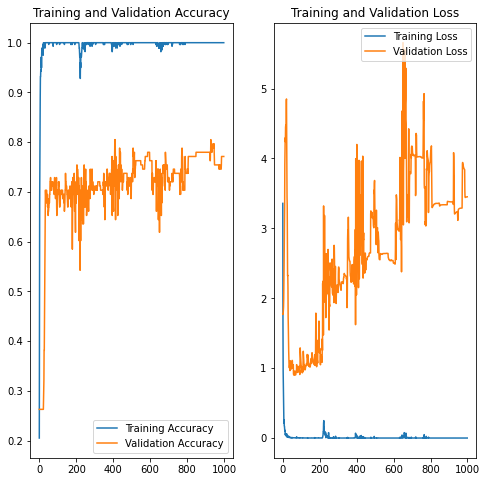

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model_path = "./model/improved_model_3.h5"


img_height = 112
img_width = 112

In [28]:
image_path = "./catfish.jpg"

In [29]:
def Dataization(image_path, img_w, img_h):
    img = PIL.Image.open(image_path)
    img = img.convert("RGB")
    img = img.resize((img_w, img_h))
    img_data = np.asarray(img)
    return img_data/255

In [30]:
pred_data = [Dataization(image_path, img_width, img_height)]
pred_data = np.array(pred_data)

In [31]:
# # Load Model (.h5 file)
pred_model = load_model(model_path)
# # Predict and Save Result
pred_result = pred_model.predict(pred_data)[0]
pred_result = list(pred_result)
cls_idx = pred_result.index(max(pred_result))

result_percentage = [p*100 for p in pred_result]

print(f"prediction result: {result_percentage}")
print(f"{max(pred_result)*100:.2f}%")
print("이 사진은 <" + class_names[cls_idx] + ">의 사진으로 추정됩니다.")

ResourceExhaustedError: OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add]